# 771948_A23_T3A - Group Work Assignment #
# Task 2 - Multi-label image-based digit classification problem #
## Assignment by Chris Mintz 202369825 and Antonia Agunbiade 202375309 ##

---
### Additional notes from class chat ###
#### 1. Labels from dataset will be folder names
#### 2. Beware of the multi image model classifying into triplets instead of single digits. The output shape should be 1000 instead of 10
#### 3. DO NOT recombine the split data. It has to be used as is as per TA Khadjia
#### 4. From Khadjia: The provided splits into training, validation and testing were designed to simulate real-world scenarios. Teams must develop a baseline model using these splits and gthen improve upon this baseline through various techniques such as preprocessing and model architecture enhancements.
---

# Task 6 - Load and preprocess the dataset for multi-label image-based digit classification task

## <b>References</b>

Johns, Ray. (2024). PyTorch vs TensorFlow for your Python Deep Learning Project. Available at: https://realpython.com/pytorch-vs-tensorflow/. [Accessed Aug 5, 2024]

In [6]:
# For this assignment we have chosen to use the TensorFlow over PyTorch as TensorFlow 2.0 has eager execution and the Keras APIs have more prefabricated components for us to use.
import tensorflow as tf
# TO DO: we might be able to remove this global import
from tensorflow import keras
# there is a lint problem access problem with the latest release of TensorFlow/Keras so we have to go direct to the root call
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input

# Chnage directory location as needed. This should be the root of the unzipped dataset and the initial folder visible shuold be "triple_mnist" 
dataset_root_dir = 'z:'

# Define our data split directory locations
training_dir = dataset_root_dir + '/triple_mnist/train'
validate_dir = dataset_root_dir + '/triple_mnist/val'
test_dir = dataset_root_dir + '/triple_mnist/test'

# Define our image parameters
image_height = 84
image_width = 84
batch_size = 32
# though these are grayscale images, we will use 3 channels to make the model more general
channels = 1
# output classes will be 0 to 9 which = 10
num_classes = 10
#TODO: Optimize
epochs = 10

# Data augmentation and preprocessing parameters to initialize the ImageDataGenerator
idg = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    shear_range=0.2,         # Apply shear transformations
    zoom_range=0.2,          # Apply zoom transformations
    rotation_range=40,       # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2   # Randomly shift images vertically by up to 20% of the height
)

In [7]:
# Load the images from a locally mapped source (see README.md for details on setting up local drive mapping)
# We've used the idg to load only the training images and preprocess them with the above parameters
# We're also trying some optimizations to speed up the data loading process
# Images are brought in as grayscale as they are black and white images
training_generator = idg.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Our test and validation data should not be augmented so their init is simpler
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Note use of validation data but no augmentation
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validate_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 64000 images belonging to 640 classes.
Found 20000 images belonging to 200 classes.
Found 16000 images belonging to 160 classes.


In [8]:
# check and see if all the images are the same shape before feeding them into the model
print(f'training generator shape {training_generator.image_shape}')
print(f'validation generator shape {validation_generator.image_shape}')
print(f'test generator shape {test_generator.image_shape}')


training generator shape (84, 84, 1)
validation generator shape (84, 84, 1)
test generator shape (84, 84, 1)


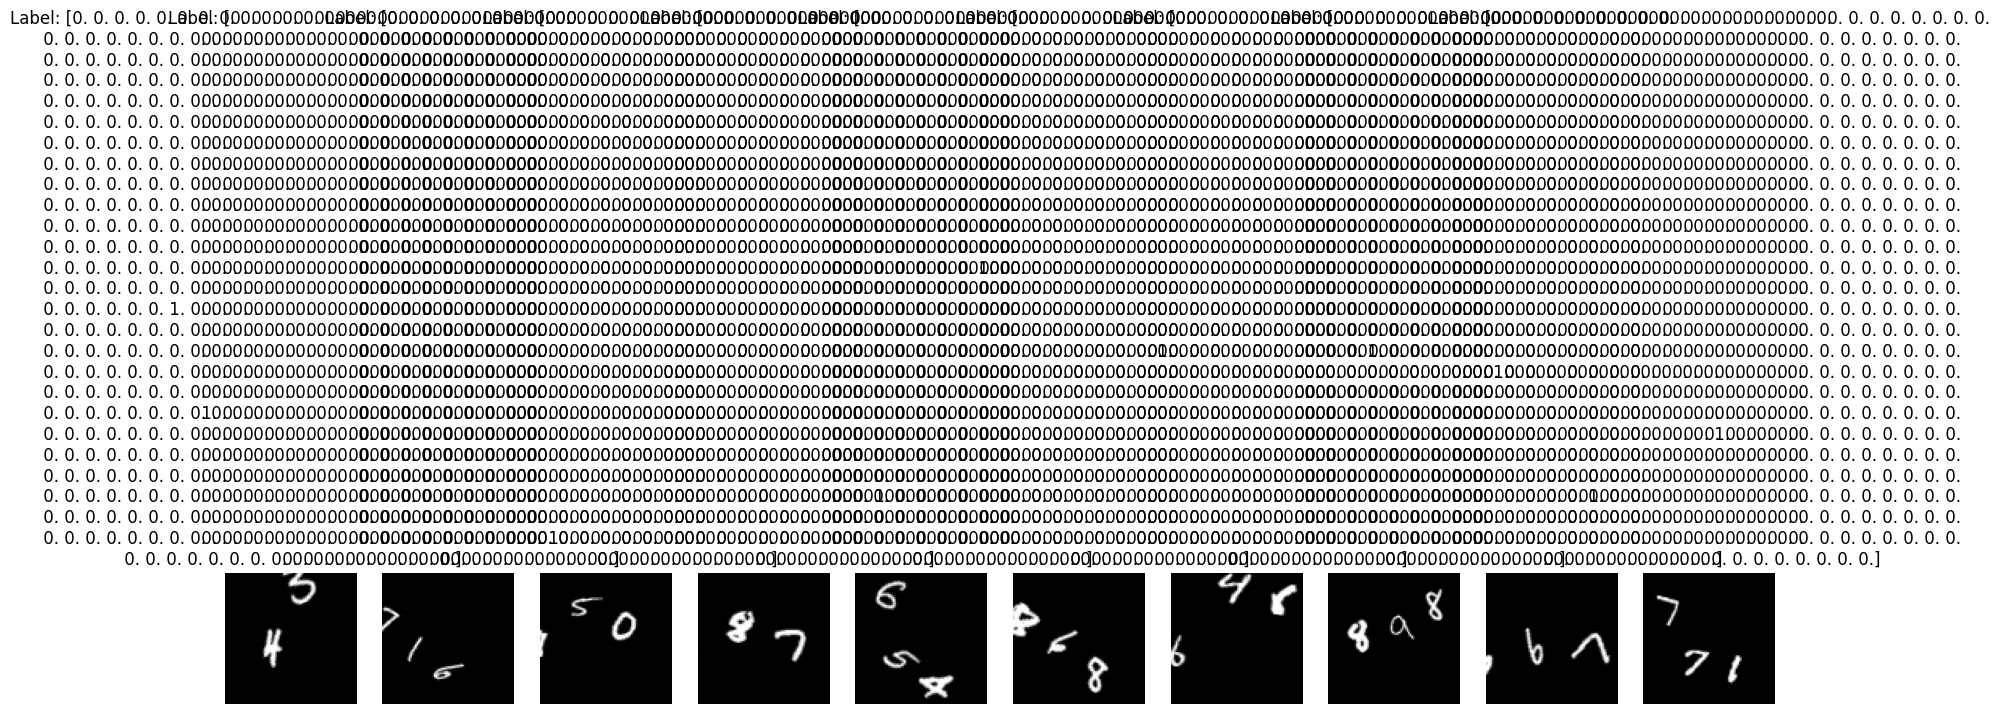

In [9]:
# let's peek into the dataset
import matplotlib.pyplot as plt
import numpy as np
# Display the first 10 digits in the training training_generator
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    ax[i].imshow(np.squeeze(training_generator[0][0][i]), cmap='gray')
    ax[i].set_title(f'Label: {training_generator[0][1][i]}')
    ax[i].axis('off')
plt.show()


# Task 7 - Build a convultional neural network (CNN) model for the multi-label image-based digit classification task

In [55]:
#TODO: The channels are bugging me so going to try to change the model to use the channels_last format and leave the var for after
#TODO: Don't forget to use Dropout layers to prevent overfitting
# Model setup
model = Sequential()
model.add(Input(shape=(image_height, image_width, channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
# Adjust the final layer to match the target shape
model.add(Dense(640, activation='softmax'))

# Show the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 82, 82, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 41, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 41, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 53792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │     6,885,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 640)            │        82,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,968,384 (26.58 MB)

 Trainable params: 6,968,384 (26.58 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Time to fit the model
model.fit(training_generator, epochs=1, validation_data=validation_generator)

ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 640), output.shape=(None, 640)

In [ ]:
# Parked model for now
model.fit(
        training_generator,
        steps_per_epoch=training_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        verbose=1)

# Task 8 - Fine-tune the CNN model using appropriate techniques like hyperparameter tuning, cross-validation, etc

# Task 9 - Visualize the dataset and the CNN model's results where applicable with feature maps, learning curves, etc

# Task 10 - Report the final performance of the CNN model using appropriate performance metrics like accuracy, F1-score, etc

# Task 11 -Decide on the best model for classification and CNN architecture for digital recognition